# tau classification tuning

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import apply_jitter, get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


In [4]:
kfold = None

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset, kfold=300)
trainloader = get_loader(trainset, kfold=kfold)
testloader = get_loader(testset, kfold=kfold)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

name = 'homeohots'
homeo = True
timestr = '2022-06-15'
dataset_name = 'nmnist'

Rz = [2, 4]
N_neuronz = [16, 32]
tauz = [1e4*2, 1e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = hots_nohomeo.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)

number of samples in the training set: 60000
number of samples in the testing set: 10000


In [5]:
%ls '../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_1000_(7.894736842105263, None)/'

ls: cannot access '../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_1000_(7.894736842105263, None)/': No such file or directory


In [6]:
test_path = '../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_50000.0_1000_(7.894736842105263, None)'
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
test_outputloader = get_loader(testset_output, shuffle=False)
for i in range(len(test_outputloader)):
    events, target = next(iter(test_outputloader))
    print(events.shape)

no output, process the samples first


AttributeError: 'HOTS_Dataset' object has no attribute 'num_samples'

Number of chance decisions: 0
90th quantile for number of events: 5189.200000000001
Mean accuracy: 89.5%
Last accuracy: 86.0%
Highest probability accuracy: 94.0%
Number of chance decisions: 0
90th quantile for number of events: 5189.200000000001
Mean accuracy: 90.4%
Last accuracy: 91.0%
Highest probability accuracy: 96.0%
Number of chance decisions: 0
90th quantile for number of events: 5189.200000000001
Mean accuracy: 90.2%
Last accuracy: 93.0%
Highest probability accuracy: 94.0%
Number of chance decisions: 0
90th quantile for number of events: 5189.200000000001
Mean accuracy: 89.8%
Last accuracy: 91.0%
Highest probability accuracy: 95.0%
Number of chance decisions: 0
90th quantile for number of events: 5189.200000000001
Mean accuracy: 89.9%
Last accuracy: 88.0%
Highest probability accuracy: 92.0%
Number of chance decisions: 0
90th quantile for number of events: 5189.200000000001
Mean accuracy: 17.299999999999997%
Last accuracy: 16.0%
Highest probability accuracy: 11.0%
Number of chan

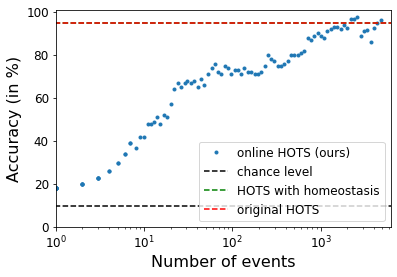

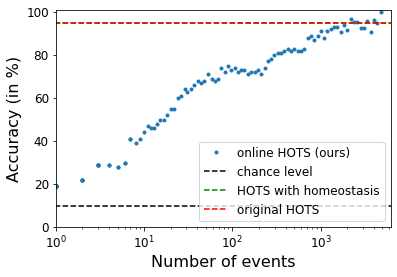

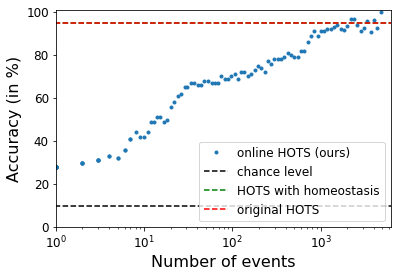

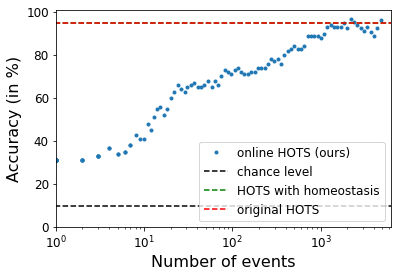

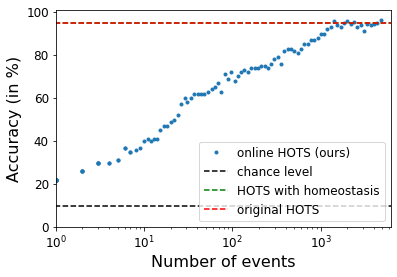

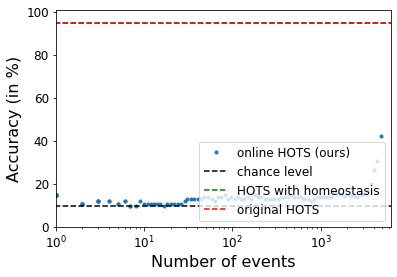

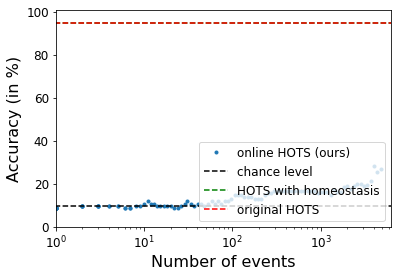

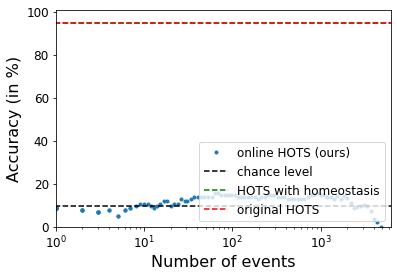

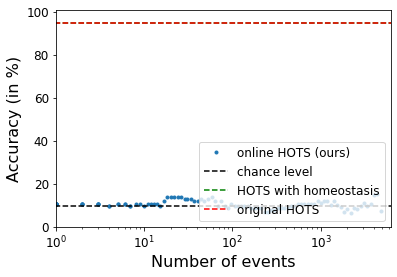

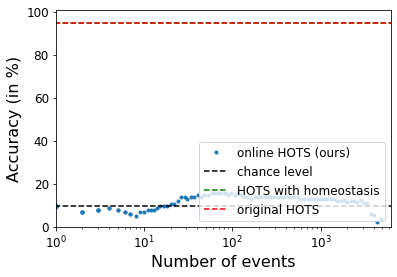

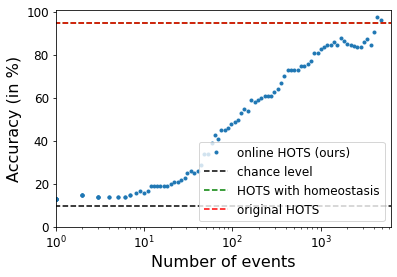

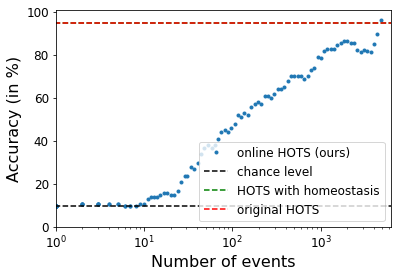

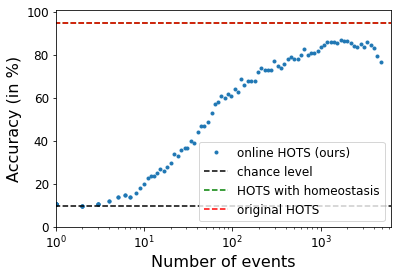

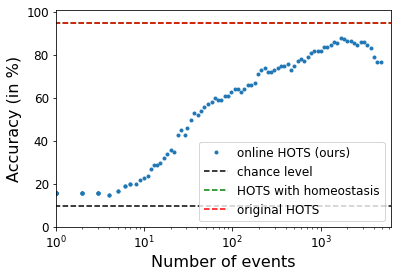

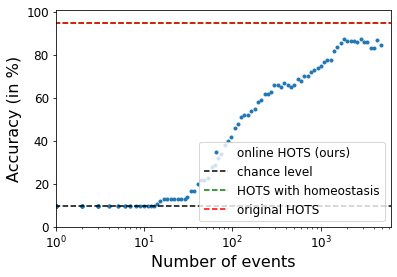

In [14]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla_list = [1e4, 2e4, 3e4, 4e4, 6e4, 7e4, 8e4, 9e4, 1e5, 2e5, 3e5, 5e5, 6e5, 7e5, 8e5]
num_sample_train = 600
num_sample_test = 100
#tau_cla_list = [5e4]

#num_sample_test = 30
#tau_cla_list = [5e5, 2e6, 3e6, 5e6, 2e7, 3e7, 4e7, 5e7, 2e8, 3e8, 5e8]

for tau_cla in tau_cla_list:
    train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
    test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
    test_path = '2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_50000.0_1000_(7.894736842105263, None)'
    model_path = f'../Records/networks/{hots.name}_{tau_cla}_{num_sample_train}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
    results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{num_sample_test}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
    
    with open(results_path, 'rb') as file:
        likelihood, true_target, timestamps = pickle.load(file)
        
    score = .95
    score_nohomeo = .95
    mlr_threshold = None
    meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)#, figure_name = 'nmnist_online.pdf')

In [25]:
with open(model_path, 'rb') as file:
    classif_layer, mean_loss_epoch = pickle.load(file)

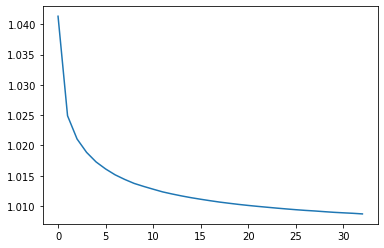

In [26]:
plt.plot(mean_loss_epoch)

In [18]:
with open(results_path, 'rb') as file:
    likelihood, true_target, timestamps = pickle.load(file)

Number of chance decisions: 0
90th quantile for number of events: 5565.0
Mean accuracy: 11.1%
Last accuracy: 9.6%
Highest probability accuracy: 12.0%


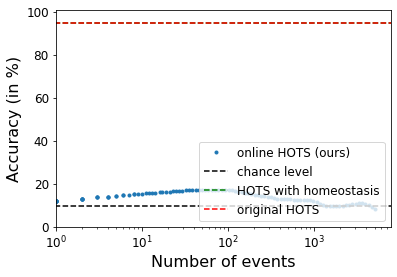

In [21]:
score = .95
score_nohomeo = .95
mlr_threshold = None
meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)#, figure_name = 'nmnist_online.pdf')

Number of chance decisions: 0
90th quantile for number of events: 5565.0
Mean accuracy: 11.1%
Last accuracy: 9.6%
Highest probability accuracy: 12.0%


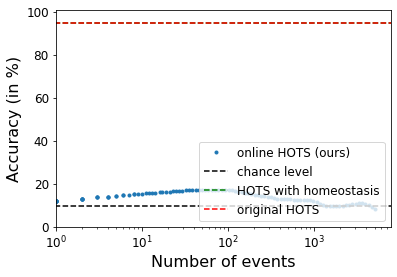

In [22]:
mlr_threshold = .6
meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)#, figure_name = 'nmnist_online.pdf')

In [15]:
%ls '../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_500000.0_*'

ls: cannot access '../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_500000.0_*': No such file or directory
